# Generate features

This notebook demonstrates how to generate features from the (SPADL representation) of the event stream data of a game. The notebook will illustrate how to compute features from individual actions, sequences of actions (i.e., gamestates) and StatsBomb events.

In [1]:
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

from socceraction import spadl
from socceraction.atomic import spadl as atomic_spadl

## Load dataset
We will use our dataset with StatsBomb events and corresponding SPADL actions of the Big 5 leagues in 2015/16. The `1.1-load-statsbomb-data` notebook explains how to create this dataset and the `1.2-convert-events-to-actions` notebook adds the SPADL representation of the events.

In [3]:
from pathlib import Path
from socceraction.data import HDFDataset, PartitionIdentifier

data_dir = Path("../../data")

# Open a HDF dataset
dataset = HDFDataset(
    path=(data_dir / "statsbomb-bigfive-1516.h5"), 
    mode="r"
)

We will explore the data of a selected game. Here, we chose the game between Liverpool and Manchester United on 12/09/2015, but the notebook can also be run for a match of your choice.

In [4]:
game = dataset.games().query("game_id==3754003").iloc[0]
df_events = dataset.read_table("events", partitions=[PartitionIdentifier(competition_id=2, season_id=27, game_id=3754003)])
df_actions = dataset.read_table("actions", partitions=[PartitionIdentifier(competition_id=2, season_id=27, game_id=3754003)])
df_atomic_actions = dataset.read_table("atomic_actions", partitions=[PartitionIdentifier(competition_id=2, season_id=27, game_id=3754003)])

SPADL stores the type, result and bodypart, team and player of actions as integer IDs. For convenience, we will also add the names to the dataframes.

In [5]:
df_actions = (
    spadl.utils.add_names(df_actions)
    .merge(dataset.players(), how="left", on=['player_id', 'team_id'])
    .merge(dataset.teams(), how="left", on='team_id')
)
df_atomic_actions = (
    atomic_spadl.utils.add_names(df_atomic_actions)
    .merge(dataset.players(), how="left", on=['player_id', 'team_id'])
    .merge(dataset.teams(), how="left", on='team_id')
)

We'll also add a nicely formated time string, which is convenient for visualizing the data.

In [6]:
def nice_time(row):
    minute = int((row['period_id'] >= 2) * 45 + (row['period_id'] >= 3) * 15 + 
                 (row['period_id'] == 4) * 15 + row['time_seconds'] // 60)
    second = int(row['time_seconds'] % 60)
    return f'{minute}m{second}s'

df_actions['nice_time'] = df_actions.apply(nice_time, axis=1)
df_atomic_actions['nice_time'] = df_atomic_actions.apply(nice_time, axis=1)

For direction of play, SPADL uses the "home team attacks to the right" convention; this means that regardless of the actual orientation of the field in any given match, all data is normalized such that the home team's offensive actions are represented as moving from left to right on the x-axis of the dataset. While for the away team, all offensive actions are represented as moving from right to left. When training a model on the data, you might want to normalize the direction of play such that the lower x-coordinates represent the own half of the team performing the action. This can be done conveniently using the `play_left_to_right` function.

In [7]:
df_actions_ltr = spadl.utils.play_left_to_right(df_actions, game.home_team_id)
df_atomic_actions_ltr = atomic_spadl.utils.play_left_to_right(df_atomic_actions, game.home_team_id)

Below, the effect of the `play_left_to_right` transformation is visualized.

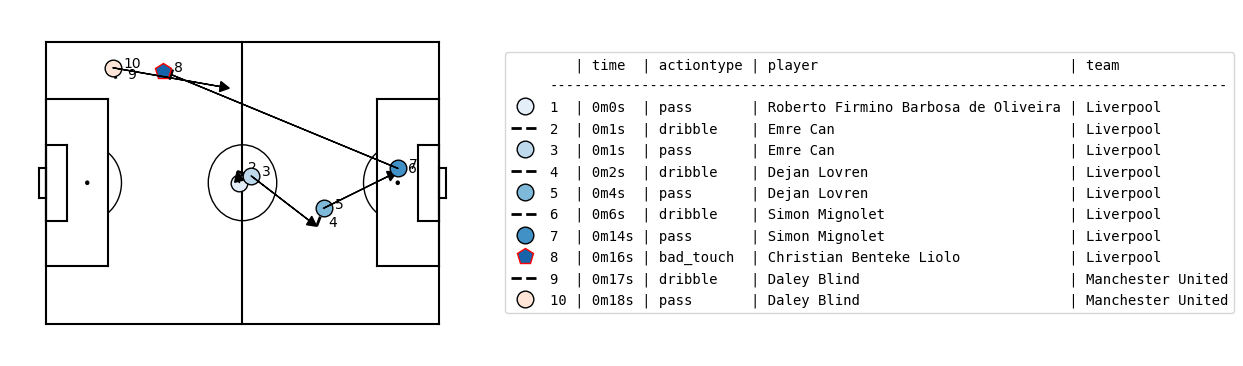

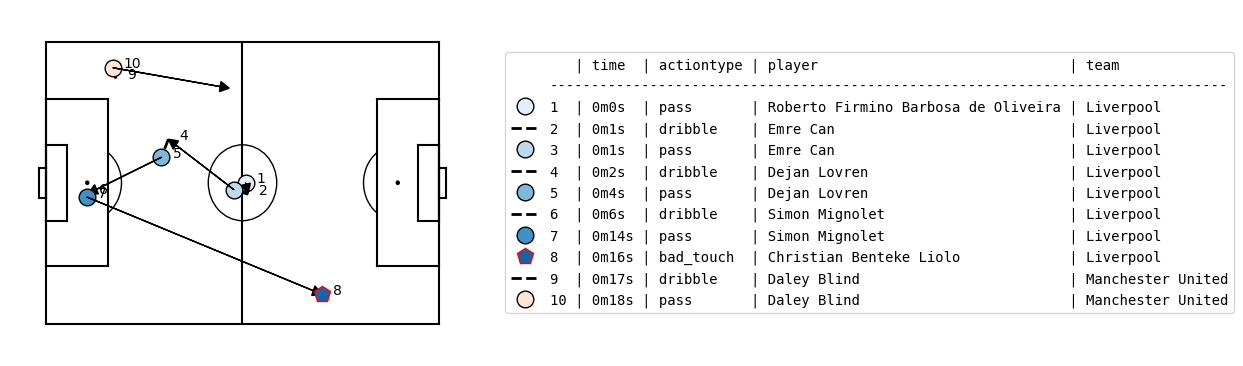

In [8]:
import matplotsoccer

def plot_actions(df_actions_to_plot):
    matplotsoccer.actions(
        location=df_actions_to_plot[['start_x', 'start_y', 'end_x', 'end_y']],
        action_type=df_actions_to_plot['type_name'],
        team=df_actions_to_plot['team_name'],
        result=df_actions_to_plot['result_name'] == 'success',
        label=df_actions_to_plot[['nice_time', 'type_name', 'player_name', 'team_name']],
        labeltitle=['time', 'actiontype', 'player', 'team'],
        zoom=False,
        figsize=6)

plot_actions(df_actions[:10])
plot_actions(df_actions_ltr[:10])

## From actions to features

### Individual action features

Every action has several characteristics, these include:

- start location
- end location
- action type
- bodypart used
- result (successful or not)
- time in the match

We will first take a look at how we can represent locations. The `socceraction.features` module already contains many feature generators that encode the location of an action. Below, we compute the raw start location of the action and the distance and angle to the center of the goal.

In [9]:
from socceraction import features

df_features = pd.concat([
    features.startlocation(df_actions_ltr),
    features.startpolar(df_actions_ltr),
], axis=1)
df_features.head()

,start_x,start_y,start_dist_to_goal,start_angle_to_goal
0,53.33125,33.9575,51.668767,0.000823
1,53.94375,31.2375,51.130931,0.054054
2,50.18125,32.3425,54.843802,0.030227
3,32.68125,44.4975,73.076666,0.144149
4,30.84375,40.1625,74.411866,0.082911


Yet, there are many other ways in which you can represent a location. For example, the following cell implements a feature generator that adds a column indicating whether the action starts and/or ends in the opponent penalty box. A feature generator takes the dataframe with the actions of a single game and a boolean mask that selects for which actions the feature should be computed, and returns a dataframe with the features.

In [10]:
from socceraction.features.utils import feature_generator

@feature_generator("actions", features=["start_inside_penalty_box", "end_inside_penalty_box"])
def inside_opp_penalty_box(actions, mask):
    result = pd.DataFrame(index=actions.index)
    for side in ['start', 'end']:
            result[f'{side}_inside_penalty_box'] = (
                (df_actions[f'{side}_x'] > (spadl.config.field_length-16.5)) & 
                (df_actions[f'{side}_y'] > (13.85)) & 
                (df_actions[f'{side}_y'] > (spadl.config.field_width-13.85))
            )
    return result.loc[mask]

In [11]:
df_features = pd.concat([
    features.startlocation(df_actions_ltr),
    features.startpolar(df_actions_ltr),
    inside_opp_penalty_box(df_actions_ltr),
], axis=1)
df_features.head()

,start_x,start_y,start_dist_to_goal,start_angle_to_goal,start_inside_penalty_box,end_inside_penalty_box
0,53.33125,33.9575,51.668767,0.000823,False,False
1,53.94375,31.2375,51.130931,0.054054,False,False
2,50.18125,32.3425,54.843802,0.030227,False,False
3,32.68125,44.4975,73.076666,0.144149,False,False
4,30.84375,40.1625,74.411866,0.082911,False,False


Just like socceraction provides a transormer for converting from events to actions, it also includes a transformer for transforming actions to features.

In [12]:
from socceraction.data.transforms import ActionsToFeatures

to_features = ActionsToFeatures(xfns=[
    features.startlocation,
    features.startpolar,
    inside_opp_penalty_box,
], convert_ltr=True)
to_features(game, df_actions).head()

,game_id,action_id,original_event_id,start_x,start_y,start_dist_to_goal,start_angle_to_goal,start_inside_penalty_box,end_inside_penalty_box
0,3754003,0,62a30bca-fd29-46f2-86e8-02b009ed2cfa,53.33125,33.9575,51.668767,0.000823,False,False
1,3754003,1,fe87af88-d765-4172-85d1-beb8cb2bae6c,53.94375,31.2375,51.130931,0.054054,False,False
2,3754003,2,619fa6d8-2d84-459d-a145-8f0d3be50a90,50.18125,32.3425,54.843802,0.030227,False,False
3,3754003,3,67ab0daa-7fd8-47ca-86ea-93a1b285db10,32.68125,44.4975,73.076666,0.144149,False,False
4,3754003,4,969c870f-69c5-4908-9ab5-a433341dd3e3,30.84375,40.1625,74.411866,0.082911,False,False


### Game state features

Often, we are interested in describing the context in which an action is executed, rather than the action itself. We refer to this context as "the game state". This includes information on the previous actions, but also more contextual features like the score and time in the match.

#### Sequence features

To compute features for action sequences, we first convert the actions to their gamestate representation. In this representation a gamestate is represented as a list of action dataframes $[a_0,a_1,\ldots]$ where each row in the $a_i$ dataframe contains the previous action of the action in the same row in the $a_{i-1}$th dataframe.

In the ["Actions Speak Louder than Goals: Valuing Player Actions in Soccer."](https://arxiv.org/abs/1802.07127) paper we take the three actions leading to the game state into account. We investigated how many actions we should include and got the best results for three actions back.

In [13]:
from socceraction.spadl import to_gamestates

dfs_gamestates = to_gamestates(df_actions, nb_prev_actions=3)
dfs_gamestates_ltr = spadl.utils.play_left_to_right(dfs_gamestates, game.home_team_id)

Notice how this representation differs from simply taking a sequence of three actions. In the example below, we show the game state representation of a dribble by Daley Blind. Mignolet (Liverpool) kicks the ball forward (1), Benteke (Liverpool) does not manage to control it (2) and Blind (Manchester United) then pikcs it up (3). In the left-to-right representation of the actions, all actions are transformed in function of the team that executes the action while in the left-to-right representation of the gamestates, the actions are transformed in function of the team that executes the last action of the game state. This ensures that we can, for example, compute the distances between actions in the same sequence.

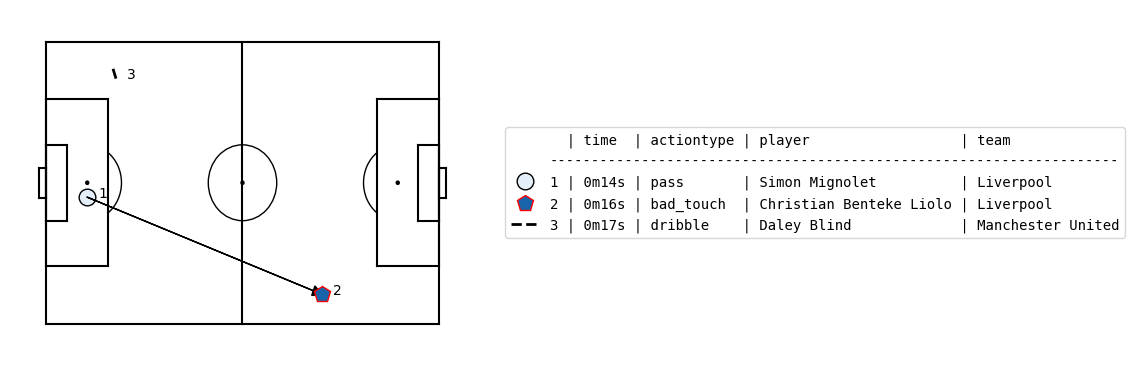

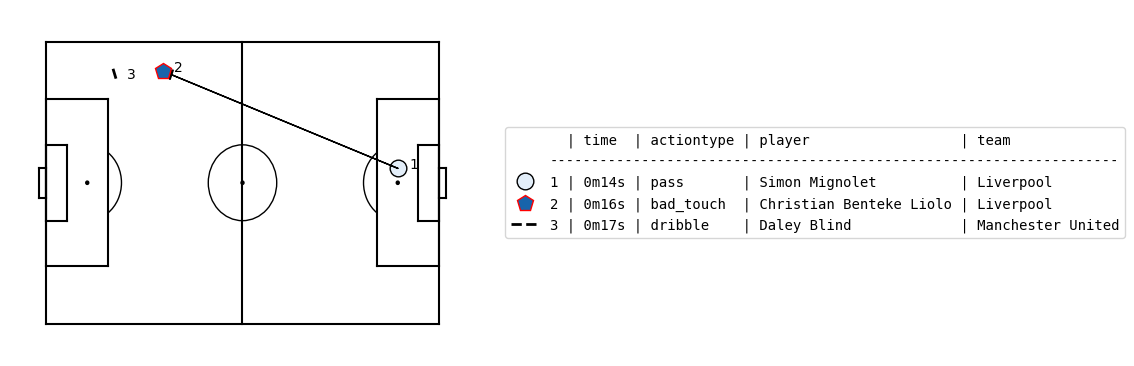

In [14]:
plot_actions(df_actions_ltr.iloc[6:9])
plot_actions(pd.concat([dfs_gamestates_ltr[i].iloc[[8]] for i in range(3)[::-1]]))

We can compute the same location features as we computed above for action on the gamestates. Therefore, we transform the feature generators by wrapping them with the `create_gamestate_features` decorator. Instead of computing the location of the current action, they will now compute features that describe the location of the current and two previous actions. The features that describe the location of the current action get suffix `a0`. The ones that describe the location of the previous action get suffix `a1`, and so on.

In [15]:
df_features = pd.concat([
    features.utils.create_gamestate_features(features.startlocation)(dfs_gamestates_ltr),
    features.utils.create_gamestate_features(features.startpolar)(dfs_gamestates_ltr),
    features.utils.create_gamestate_features(inside_opp_penalty_box)(dfs_gamestates_ltr)
], axis=1)
df_features.head()

,start_x_a0,start_y_a0,start_x_a1,start_y_a1,start_x_a2,start_y_a2,start_dist_to_goal_a0,start_angle_to_goal_a0,start_dist_to_goal_a1,start_angle_to_goal_a1,start_dist_to_goal_a2,start_angle_to_goal_a2,start_inside_penalty_box_a0,end_inside_penalty_box_a0,start_inside_penalty_box_a1,end_inside_penalty_box_a1,start_inside_penalty_box_a2,end_inside_penalty_box_a2
0,53.33125,33.9575,53.33125,33.9575,53.33125,33.9575,51.668767,0.000823,51.668767,0.000823,51.668767,0.000823,False,False,False,False,False,False
1,53.94375,31.2375,53.33125,33.9575,53.33125,33.9575,51.130931,0.054054,51.668767,0.000823,51.668767,0.000823,False,False,False,False,False,False
2,50.18125,32.3425,53.94375,31.2375,53.33125,33.9575,54.843802,0.030227,51.130931,0.054054,51.668767,0.000823,False,False,False,False,False,False
3,32.68125,44.4975,50.18125,32.3425,53.94375,31.2375,73.076666,0.144149,54.843802,0.030227,51.130931,0.054054,False,False,False,False,False,False
4,30.84375,40.1625,32.68125,44.4975,50.18125,32.3425,74.411866,0.082911,73.076666,0.144149,54.843802,0.030227,False,False,False,False,False,False


Some features add extra context that is computed over the entire sequence. For example, the cell below computes the distance covered in x and y direction as well as the time passed in the sequence. These features might tell the model something about the speed of play, whether the game quickly progressed from one side to another (probably indicating a counter attack) or whether it is a slow build up play.

In [16]:
df_features = pd.concat([
    features.space_delta(dfs_gamestates_ltr),
    features.time_delta(dfs_gamestates_ltr),
], axis=1)
df_features.head()

,dx_a01,dy_a01,mov_a01,dx_a02,dy_a02,mov_a02,time_delta_1,time_delta_2
0,0.6125,-2.72,2.78811,0.6125,-2.720,2.788110,0.000,0.000
1,0.0000,0.00,0.00000,0.0000,0.000,0.000000,0.626,0.626
2,0.0000,0.00,0.00000,3.7625,-1.105,3.921407,0.375,1.001
3,0.0000,0.00,0.00000,17.5000,-12.155,21.307136,1.566,1.941
4,0.0000,0.00,0.00000,1.8375,4.335,4.708358,1.269,2.835


#### Contextual features

Finally, you might want to add some additional context that is computed over all actions up to a certain point in the game. For example, the time in the match and the current score in the match might influence the value of the game state.

In [17]:
df_features = pd.concat([
    features.time(df_actions_ltr),
    features.goalscore(df_actions_ltr),
], axis=1)
df_features.head()

,period_id,time_seconds,time_seconds_overall,goalscore_team,goalscore_opponent,goalscore_diff
0,1,0.381,0.381,0,0,0
1,1,1.007,1.007,0,0,0
2,1,1.382,1.382,0,0,0
3,1,2.948,2.948,0,0,0
4,1,4.217,4.217,0,0,0


### Computing features for a dataset

Just like socceraction provides a transormer for converting from events to actions, it also includes a transformer for transforming actions to features.

In [18]:
from socceraction.data.transforms import ActionsToFeatures

to_features = ActionsToFeatures(xfns=[
    features.startlocation,
    features.utils.create_gamestate_features(features.startpolar),
    features.goalscore,
], nb_prev_actions=2)
to_features(game, df_actions).head()

,game_id,action_id,original_event_id,start_x,start_y,start_dist_to_goal_a0,start_angle_to_goal_a0,start_dist_to_goal_a1,start_angle_to_goal_a1,goalscore_team,goalscore_opponent,goalscore_diff
0,3754003,0,62a30bca-fd29-46f2-86e8-02b009ed2cfa,53.33125,33.9575,53.331267,0.000797,53.331267,0.000797,0,0,0
1,3754003,1,fe87af88-d765-4172-85d1-beb8cb2bae6c,53.94375,31.2375,54.014439,0.051166,53.331267,0.000797,0,0,0
2,3754003,2,619fa6d8-2d84-459d-a145-8f0d3be50a90,50.18125,32.3425,50.208616,0.033018,54.014439,0.051166,0,0,0
3,3754003,3,67ab0daa-7fd8-47ca-86ea-93a1b285db10,32.68125,44.4975,34.325815,0.310799,50.208616,0.033018,0,0,0
4,3754003,4,969c870f-69c5-4908-9ab5-a433341dd3e3,30.84375,40.1625,31.453351,0.197201,34.325815,0.310799,0,0,0


You can either provide feature generators as above, or directly specify the names of the features you want.

In [19]:
to_features = ActionsToFeatures(xfns=[
    "start_x",
    "start_angle_to_goal",
    "start_inside_penalty_box",
    "goalscore_diff",
], convert_ltr=True)
to_features(game, df_actions).head()

,game_id,action_id,original_event_id,start_x,start_angle_to_goal,start_inside_penalty_box,goalscore_diff
0,3754003,0,62a30bca-fd29-46f2-86e8-02b009ed2cfa,53.33125,0.000823,False,0
1,3754003,1,fe87af88-d765-4172-85d1-beb8cb2bae6c,53.94375,0.054054,False,0
2,3754003,2,619fa6d8-2d84-459d-a145-8f0d3be50a90,50.18125,0.030227,False,0
3,3754003,3,67ab0daa-7fd8-47ca-86ea-93a1b285db10,32.68125,0.144149,False,0
4,3754003,4,969c870f-69c5-4908-9ab5-a433341dd3e3,30.84375,0.082911,False,0


Once you are happy with the feature set, you can apply it to the entire dataset or a partition of the dataset.

In [20]:
df_features = dataset.transform(
    to_features, 
    from_table="actions", 
    to_table=None, 
    partitions=[PartitionIdentifier(competition_id=2, season_id=27, game_id=3754003)]
)
df_features.head()

Transforming dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]


,game_id,action_id,original_event_id,start_x,start_angle_to_goal,start_inside_penalty_box,goalscore_diff
0,3754003,0,62a30bca-fd29-46f2-86e8-02b009ed2cfa,53.33125,0.000823,False,0
1,3754003,1,fe87af88-d765-4172-85d1-beb8cb2bae6c,53.94375,0.054054,False,0
2,3754003,2,619fa6d8-2d84-459d-a145-8f0d3be50a90,50.18125,0.030227,False,0
3,3754003,3,67ab0daa-7fd8-47ca-86ea-93a1b285db10,32.68125,0.144149,False,0
4,3754003,4,969c870f-69c5-4908-9ab5-a433341dd3e3,30.84375,0.082911,False,0


## From events to features

The advantage of computing features based on the SPADL representation of actions is that the feature generators can be reused for all data providers. However, SPADL only contains a subset of all information that is contained in the original events. Sometimes, you might want to use this additional information. In that case, you can compute features based on the original event data.

Below is an example of how to implement a feature generator that extracts the height of a pass from StatsBomb event data.

In [21]:
from socceraction.features.utils import feature_generator

@feature_generator("events", features=["pass_height"])
def statsbomb_pass_height(events, mask):
    output = {}
    for idx, event in events.loc[mask].iterrows():
        if "pass" in event.extra and "height" in event.extra['pass']:
            output[idx] = {"pass_height": event.extra["pass"]['height']['name']}

    output = pd.DataFrame.from_dict(output, orient="index")
    return output

In [22]:
from socceraction.data.transforms import StatsBombEventsToFeatures

to_features = StatsBombEventsToFeatures(xfns=[
    statsbomb_pass_height,
])
to_features(game, df_events)

,original_event_id,pass_height
0,62a30bca-fd29-46f2-86e8-02b009ed2cfa,Low Pass
1,619fa6d8-2d84-459d-a145-8f0d3be50a90,Ground Pass
2,969c870f-69c5-4908-9ab5-a433341dd3e3,Ground Pass
3,273237f0-2163-40f8-b9ff-dd8cec572831,High Pass
4,afd9c7f5-cd4d-4a20-bc80-ee5217e15a2a,High Pass
...,...,...
1072,d66dc218-03e2-4d0a-ada2-c3e234e30ae4,Ground Pass
1073,21fbd3d9-eb99-41e4-9ed1-d040c118bd96,Ground Pass
1074,8c46445f-b021-40ee-ad40-d491182a5e36,Ground Pass
1075,cbce8471-4980-4b0f-b8c2-2138e6507b8c,Ground Pass


The features that are computed from events can be combined with features that are computed from actions by joining on the `original_event_id`. Below, we illustrate this by combining a feature that computes the distance of a pass along the x-axis (from the actions) with the pass height (from the events).

In [23]:
class PassesToFeatures:
    def __init__(self):
        self.actions_to_features = ActionsToFeatures(
            xfns=["dx"], 
            mask_fn=lambda a: a.type_id == spadl.config.actiontypes.index("pass")
        )
        self.events_to_features = StatsBombEventsToFeatures(
            xfns=["pass_height"]
        )
        
    def __call__(self, game, inputs):
        events, actions = inputs
        action_features = self.actions_to_features(game, actions)
        event_features = self.events_to_features(game, events)
        return pd.merge(action_features, event_features, on="original_event_id", how="left")

to_features = PassesToFeatures()
df_features = to_features(game, (df_events, df_actions,))
df_features.head()

,game_id,action_id,original_event_id,dx,pass_height
0,3754003,0,62a30bca-fd29-46f2-86e8-02b009ed2cfa,0.6125,Low Pass
1,3754003,2,619fa6d8-2d84-459d-a145-8f0d3be50a90,-17.5000,Ground Pass
2,3754003,4,969c870f-69c5-4908-9ab5-a433341dd3e3,-19.6000,Ground Pass
3,3754003,6,273237f0-2163-40f8-b9ff-dd8cec572831,62.8250,High Pass
4,3754003,9,afd9c7f5-cd4d-4a20-bc80-ee5217e15a2a,31.1500,High Pass


Then, we can compute for example the average vertical distance of a ground, low and high pass.

In [24]:
df_features['dx'] = df_features['dx'].abs()
df_features.groupby("pass_height")['dx'].mean().sort_values()

pass_height
Ground Pass     8.740459
Low Pass       10.690909
High Pass      23.726827
Name: dx, dtype: float64

In [25]:
dataset.close()